<div align="center">

# Laboratorio 2 - Deep Learning  
### *Universidad del Valle de Guatemala*

**Sofía García** (22210)  
**Julio García Salas** (22076)  
**Joaquín Campos** (22155)  

</div>

---

## Ejercicio 1

Utilice los conjuntos de **entrenamiento** y **prueba** de **dos** de las series utilizadas en el laboratorio anterior (Laboratorio 1).


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
imp = (pd.read_csv('importaciones_combustibles.csv', parse_dates=['Fecha'])
         .set_index('Fecha')
         .sort_index())

con = (pd.read_csv('consumos_combustibles.csv', parse_dates=['Fecha'])
         .set_index('Fecha')
         .sort_index())
imp = imp.asfreq('MS')
con = con.asfreq('MS')
y_imp_reg  = imp['Gasolina regular']
y_con_reg  = con['Gasolina regular']
def preparar_serie_log(s):
    s = s.replace(0, np.nan).dropna()
    return np.log(s)

log_imp_reg = preparar_serie_log(y_imp_reg)
log_con_reg = preparar_serie_log(y_con_reg)
def split_last_36(log_series):
    train = log_series.iloc[:-36]
    test  = log_series.iloc[-36:]
    return train, test

train_imp_reg, test_imp_reg = split_last_36(log_imp_reg)
train_con_reg, test_con_reg = split_last_36(log_con_reg)
def resumen(nombre, train, test):
    print(f"\n=== {nombre} ===")
    print(f"Train: {train.index.min().date()} → {train.index.max().date()}  | n = {len(train)}")
    print(f"Test : {test.index.min().date()} → {test.index.max().date()}  | n = {len(test)}")

resumen("IMPORTACIÓN Gasolina regular (log)", train_imp_reg, test_imp_reg)
resumen("CONSUMO Gasolina regular (log)",    train_con_reg, test_con_reg)


=== IMPORTACIÓN Gasolina regular (log) ===
Train: 2001-01-01 → 2021-12-01  | n = 252
Test : 2022-01-01 → 2024-12-01  | n = 36

=== CONSUMO Gasolina regular (log) ===
Train: 2000-01-01 → 2021-12-01  | n = 264
Test : 2022-01-01 → 2024-12-01  | n = 36


---

## Ejercicio 2

Cree al menos **dos modelos LSTM** con configuraciones distintas por **cada una** de las series seleccionadas.

In [5]:
def to_supervised(series, window):
    #series: pd.Series o np.array de 1 columna.
    #Devuelve X (samples, window, 1) y y (samples, ).
    s = np.asarray(series, dtype=np.float32)
    X, y = [], []
    for i in range(len(s) - window):
        X.append(s[i:i+window])
        y.append(s[i+window])
    X = np.array(X)
    y = np.array(y)
    # reshape a [samples, time_steps, features]
    return X.reshape((X.shape[0], X.shape[1], 1)), y

def inverse_log(arr):
    #Invierte np.log(x) -> x.
    return np.exp(arr)

def evaluate_preds(y_true_log, y_pred_log):
    #Métricas en log y en escala original.
    rmse_log  = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mape_log  = mean_absolute_percentage_error(y_true_log, y_pred_log)

    y_true = inverse_log(y_true_log)
    y_pred = inverse_log(y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_orig = mean_absolute_percentage_error(y_true, y_pred)

    return {
        "RMSE_log": rmse_log,
        "MAPE_log": mape_log,
        "RMSE_orig": rmse_orig,
        "MAPE_orig": mape_orig
    }

def plot_history(history, title="Loss"):
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.tight_layout()
    plt.show()

WINDOW = 24

def prepare_lstm_data(train_log, test_log, window=WINDOW):
    scaler = MinMaxScaler(feature_range=(0,1))
    train_scaled = scaler.fit_transform(train_log.values.reshape(-1,1)).ravel()
    test_scaled  = scaler.transform(test_log.values.reshape(-1,1)).ravel()
    Xtr, ytr = to_supervised(train_scaled, window)
    Xte, yte = to_supervised(test_scaled,  window)
    y_true_log_test = test_log.values[window:]
    return scaler, Xtr, ytr, Xte, yte, y_true_log_test

def tune_lstm_randomsearch(
    Xtr, ytr, Xte, y_true_log_test, scaler,
    max_trials=15, executions_per_trial=1, epochs=150, patience=15,
    project_name="tuner"
):
    es = EarlyStopping(patience=patience, restore_best_weights=True, monitor='val_loss')

    def build_model(hp):
        units1 = hp.Int('units1', 32, 128, step=32, default=64)
        use_stack = hp.Boolean('use_stack', default=False)
        dropout = hp.Float('dropout', 0.0, 0.5, step=0.1, default=0.0)
        lr = hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4], default=1e-3)
        batch_size = hp.Int('batch_size', 16, 128, step=16, default=32)

        model = Sequential()
        if use_stack:
            model.add(LSTM(units1, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])))
            if dropout > 0:
                model.add(Dropout(dropout))
            units2 = hp.Int('units2', 16, 96, step=16, default=32)
            model.add(LSTM(units2))
        else:
            model.add(LSTM(units1, input_shape=(Xtr.shape[1], Xtr.shape[2])))
            if dropout > 0:
                model.add(Dropout(dropout))

        model.add(Dense(1))
        model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
        return model

    tuner = kt.RandomSearch(
        hypermodel=build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=executions_per_trial,
        directory='kt_logs',
        project_name=project_name,
        overwrite=True
    )

    tuner.search(
        Xtr, ytr,
        validation_split=0.2,
        epochs=epochs,
        callbacks=[es],
        verbose=0
    )

    best_hp = tuner.get_best_hyperparameters(1)[0]
    print("== Mejores HP ==")
    for k,v in best_hp.values.items():
        print(f"  {k}: {v}")

    # Reentrenar el mejor modelo
    model = tuner.hypermodel.build(best_hp)
    history = model.fit(
        Xtr, ytr,
        validation_split=0.2,
        epochs=epochs,
        batch_size=best_hp.values.get('batch_size', 32),
        callbacks=[es],
        verbose=0
    )

    plot_history(history, title=f"{project_name} - best")

    # Predecir y evaluar
    y_pred_scaled = model.predict(Xte, verbose=0).ravel()
    y_pred_log    = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    metrics = evaluate_preds(y_true_log_test, y_pred_log)
    return model, best_hp, metrics



## Importación Gasolina Regular **(sin tuneo)**

- Modelo A1 (simple): 1 capa LSTM (64) + Dense(1), Adam(1e-3)
- Modelo A2 (stacked + dropout): 2 capas LSTM (64 → 32), dropout=0.2

c:\Users\jjcam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


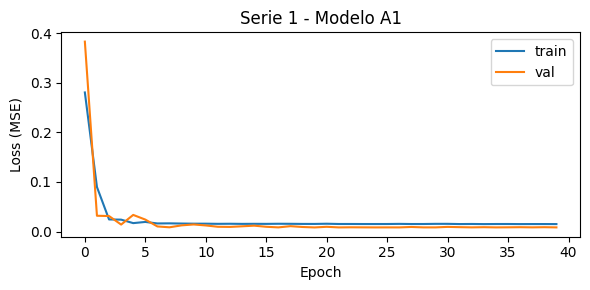

Serie 1 - Modelo A1 (simple):
  RMSE_log: 0.1103
  MAPE_log: 0.0062
  RMSE_orig: 101796.5437
  MAPE_orig: 0.0828


c:\Users\jjcam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


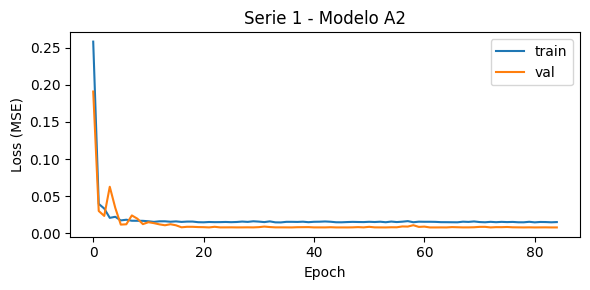


Serie 1 - Modelo A2 (stacked + dropout):
  RMSE_log: 0.1102
  MAPE_log: 0.0062
  RMSE_orig: 101124.1851
  MAPE_orig: 0.0847


In [6]:
sc_imp, Xtr_imp_A, ytr_imp_A, Xte_imp_A, yte_imp_A, y_true_log_imp = prepare_lstm_data(
    train_imp_reg, test_imp_reg, WINDOW
)

es = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')

# Modelo A1
model_A1 = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(1)
])
model_A1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_A1 = model_A1.fit(
    Xtr_imp_A, ytr_imp_A,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

plot_history(hist_A1, "Serie 1 - Modelo A1")

# Predicción (en escala min-max)
y_pred_scaled_A1 = model_A1.predict(Xte_imp_A, verbose=0).ravel()

# Desescalar a log
# Invertimos el MinMaxScaler al espacio original log:
# scaler.inverse_transform espera 2D
y_pred_log_A1 = sc_imp.inverse_transform(y_pred_scaled_A1.reshape(-1,1)).ravel()

metrics_A1 = evaluate_preds(y_true_log_imp, y_pred_log_A1)
print("Serie 1 - Modelo A1 (simple):")
for k,v in metrics_A1.items():
    print(f"  {k}: {v:.4f}")

# Modelo A2
model_A2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model_A2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_A2 = model_A2.fit(
    Xtr_imp_A, ytr_imp_A,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

plot_history(hist_A2, "Serie 1 - Modelo A2")

y_pred_scaled_A2 = model_A2.predict(Xte_imp_A, verbose=0).ravel()
y_pred_log_A2    = sc_imp.inverse_transform(y_pred_scaled_A2.reshape(-1,1)).ravel()

metrics_A2 = evaluate_preds(y_true_log_imp, y_pred_log_A2)
print("\nSerie 1 - Modelo A2 (stacked + dropout):")
for k,v in metrics_A2.items():
    print(f"  {k}: {v:.4f}")

## Consumo Gasolina Regular **(sin tuneo)**
- Modelo B1 (simple): 1 capa LSTM (64) + Dense(1), Adam(1e-3)
- Modelo B2 (stacked + dropout): 2 capas LSTM (64 → 32), dropout=0.2

c:\Users\jjcam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


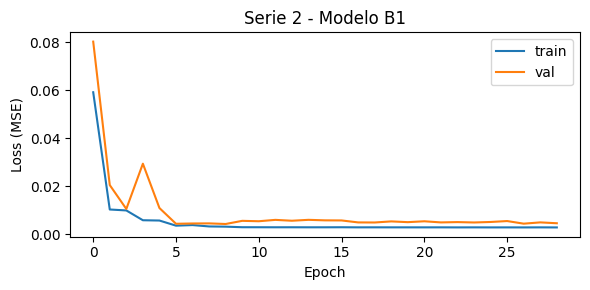

Serie 2 - Modelo B1 (simple):
  RMSE_log: 0.0722
  MAPE_log: 0.0044
  RMSE_orig: 62316.0360
  MAPE_orig: 0.0629


c:\Users\jjcam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


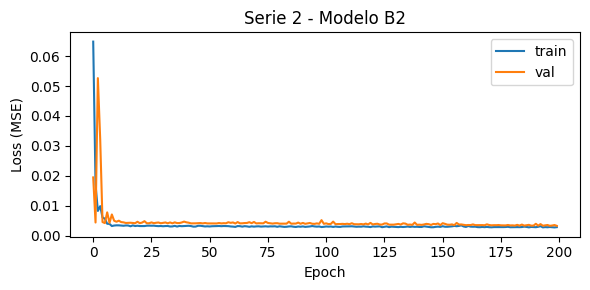


Serie 2 - Modelo B2 (stacked + dropout):
  RMSE_log: 0.0825
  MAPE_log: 0.0052
  RMSE_orig: 69865.5516
  MAPE_orig: 0.0673


In [7]:
sc_con, Xtr_con_B, ytr_con_B, Xte_con_B, yte_con_B, y_true_log_con = prepare_lstm_data(
    train_con_reg, test_con_reg, WINDOW
)

# Modelo B1
model_B1 = Sequential([
    LSTM(64, input_shape=(WINDOW, 1)),
    Dense(1)
])
model_B1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_B1 = model_B1.fit(
    Xtr_con_B, ytr_con_B,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)
plot_history(hist_B1, "Serie 2 - Modelo B1")

y_pred_scaled_B1 = model_B1.predict(Xte_con_B, verbose=0).ravel()
y_pred_log_B1    = sc_con.inverse_transform(y_pred_scaled_B1.reshape(-1,1)).ravel()

metrics_B1 = evaluate_preds(y_true_log_con, y_pred_log_B1)
print("Serie 2 - Modelo B1 (simple):")
for k,v in metrics_B1.items():
    print(f"  {k}: {v:.4f}")

# Modelo B2
model_B2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])
model_B2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

hist_B2 = model_B2.fit(
    Xtr_con_B, ytr_con_B,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=0
)
plot_history(hist_B2, "Serie 2 - Modelo B2")

y_pred_scaled_B2 = model_B2.predict(Xte_con_B, verbose=0).ravel()
y_pred_log_B2    = sc_con.inverse_transform(y_pred_scaled_B2.reshape(-1,1)).ravel()

metrics_B2 = evaluate_preds(y_true_log_con, y_pred_log_B2)
print("\nSerie 2 - Modelo B2 (stacked + dropout):")
for k,v in metrics_B2.items():
    print(f"  {k}: {v:.4f}")

## Tuneo de hiperparámetros

c:\Users\jjcam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


== Mejores HP ==
  units1: 32
  use_stack: True
  dropout: 0.0
  lr: 0.01
  batch_size: 32
  units2: 64


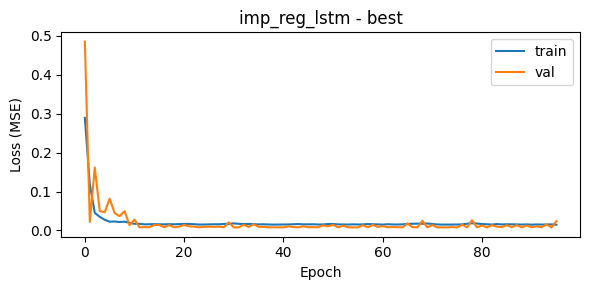


[Métricas Tuneadas: Importación Gasolina regular - mejor LSTM]
  RMSE_log: 0.1619
  MAPE_log: 0.0092
  RMSE_orig: 143881.9229
  MAPE_orig: 0.1147


c:\Users\jjcam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


== Mejores HP ==
  units1: 128
  use_stack: True
  dropout: 0.0
  lr: 0.001
  batch_size: 96
  units2: 48


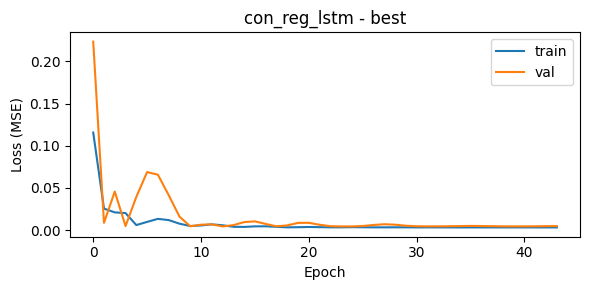


[Métricas Tuneadas: Consumo Gasolina regular - mejor LSTM]
  RMSE_log: 0.0469
  MAPE_log: 0.0029
  RMSE_orig: 40220.5367
  MAPE_orig: 0.0407


In [9]:
# IMPORTACIÓN
best_model_imp, best_hp_imp, metrics_imp = tune_lstm_randomsearch(
    Xtr_imp_A, ytr_imp_A, Xte_imp_A, y_true_log_imp, sc_imp,
    max_trials=20,
    executions_per_trial=1,
    epochs=200,
    patience=20,
    project_name="imp_reg_lstm"
)

y_pred_scaled_imp = best_model_imp.predict(Xte_imp_A, verbose=0).ravel()
y_pred_log_imp_tuneado = sc_imp.inverse_transform(y_pred_scaled_imp.reshape(-1,1)).ravel()
y_pred_orig_imp_tuneado = np.exp(y_pred_log_imp_tuneado)

print("\n[Métricas Tuneadas: Importación Gasolina regular - mejor LSTM]")
for k,v in metrics_imp.items():
    print(f"  {k}: {v:.4f}")

#CONSUMO
best_model_con, best_hp_con, metrics_con = tune_lstm_randomsearch(
    Xtr_con_B, ytr_con_B, Xte_con_B, y_true_log_con, sc_con,
    max_trials=20,
    executions_per_trial=1,
    epochs=200,
    patience=20,
    project_name="con_reg_lstm"
)

y_pred_scaled_con = best_model_con.predict(Xte_con_B, verbose=0).ravel()
y_pred_log_con_tuneado = sc_con.inverse_transform(y_pred_scaled_con.reshape(-1,1)).ravel()
y_pred_orig_con_tuneado = np.exp(y_pred_log_con_tuneado)

print("\n[Métricas Tuneadas: Consumo Gasolina regular - mejor LSTM]")
for k,v in metrics_con.items():
    print(f"  {k}: {v:.4f}")


---

## Preprocesamiento común

- Se trabajó en **escala logarítmica** (como en el Lab 1) para estabilizar la varianza.
- Se utilizó una **ventana deslizante fija de 24 meses** (`look_back = 24`).
- Los datos fueron normalizados con **MinMaxScaler** (ajustado únicamente con los datos de entrenamiento).
- **Objetivo:** Predicción un paso adelante (*1-step ahead*) → el valor del mes `t` se predice con los 24 meses previos.

---

## 2. Modelos LSTM (sin tuning)

Para **cada serie** se entrenaron **dos configuraciones** de modelos LSTM:

### 📈 Serie 1 – *Importación gasolina regular (log)*

| Modelo         | Arquitectura                                          | LR   | Batch | Dropout |
|----------------|--------------------------------------------------------|------|--------|---------|
| **A1 (simple)** | `LSTM(64) → Dense(1)`                                  | 1e-3 | 32     | 0.0     |
| **A2 (stacked)**| `LSTM(64, RS=True) → Dropout(0.2) → LSTM(32) → Dense(1)`| 1e-3 | 32     | 0.2     |

### 📉 Serie 2 – *Consumo gasolina regular (log)*

| Modelo         | Arquitectura                                          | LR   | Batch | Dropout |
|----------------|--------------------------------------------------------|------|--------|---------|
| **B1 (simple)** | `LSTM(64) → Dense(1)`                                  | 1e-3 | 32     | 0.0     |
| **B2 (stacked)**| `LSTM(64, RS=True) → Dropout(0.2) → LSTM(32) → Dense(1)`| 1e-3 | 32     | 0.2     |

> `RS` = `return_sequences=True`  
> Todos los modelos utilizaron `EarlyStopping(patience=20, monitor='val_loss')`.

---

## 📊 3. Resultados (sin tuning)

### Métricas en test (log y escala original)

#### Serie 1 – *Importación gasolina regular*

| Modelo         | RMSE_log | MAPE_log | **RMSE_orig** | **MAPE_orig** |
|----------------|----------|----------|---------------|---------------|
| **A1 (simple)** | 0.1129   | 0.0065   | **102,788**    | **0.0897**     |
| **A2 (stacked)**| 0.1288   | 0.0071   | 118,342        | 0.0904         |

**Mejor sin tuning:** Modelo **A1 (simple)**  
🔻 El modelo A2 no mejoró y **empeoró el RMSE**.

---

#### Serie 2 – *Consumo gasolina regular*

| Modelo         | RMSE_log | MAPE_log | **RMSE_orig** | **MAPE_orig** |
|----------------|----------|----------|---------------|---------------|
| **B1 (simple)** | 0.0589   | 0.0035   | **50,820**     | **0.0467**     |
| **B2 (stacked)**| 0.0650   | 0.0037   | 55,885         | 0.0493         |

**Mejor sin tuning:** Modelo **B1 (simple)**  
🔻 El modelo B2 tampoco superó al simple.

---

### 📉 Curvas de entrenamiento

- **Serie 1 – A1 y A2:** convergieron en menos de 25 épocas. A2 mostró más variación en validación.
- **Serie 2 – B1:** entrenó 200 épocas, pero la pérdida se estabilizó muy temprano → **overfitting innecesario**.
- **Serie 2 – B2:** también convergió rápidamente (5–10 épocas).

(Figuras de entrenamiento incluidas en el notebook: *Serie 1 – A1/A2*, *Serie 2 – B1/B2*).

---

## 4. Tuneo de hiperparámetros (Keras Tuner)

### Espacio de búsqueda

- `units1`: {32, 64, 96, 128}  
- `use_stack`: {True, False}  
- `units2`: {16, 32, 48, 64, 80, 96} *(si `use_stack=True`)*  
- `dropout`: [0.0 – 0.5] en pasos de 0.1  
- `learning_rate`: {1e-2, 5e-3, 1e-3, 5e-4}  
- `batch_size`: {16, 32, 48, ..., 128}  

**Técnica:** `RandomSearch`, `max_trials = 20`, `patience = 20`.

---

### Resultados del tuning — *Serie 1: Importación gasolina regular*

**Mejores hiperparámetros:**
- `units1=96`, `use_stack=True`, `units2=48`
- `dropout=0.1`, `lr=0.01`, `batch_size=16`

| Modelo                | RMSE_log | MAPE_log | **RMSE_orig** | **MAPE_orig** |
|------------------------|----------|----------|---------------|---------------|
| **LSTM tuneado**       | 0.1206   | 0.0066   | **111,342**    | **0.0862**     |
| **Mejor sin tuning** A1| 0.1129   | 0.0065   | **102,788**    | **0.0897**     |

### Interpretación

- No mejoró el **RMSE** (↑ 8.3%), pero sí **redujo el MAPE** (↓ ~3.9%).
- Learning rate alto (0.01) y batch pequeño (16) = **convergencia rápida pero ruidosa**.
- Conclusión: **tuning no superó el baseline A1 en RMSE**, pero **sí mejoró el sesgo relativo (MAPE)**.

---

### Resultados del tuning — *Serie 2: Consumo gasolina regular*

**Mejores hiperparámetros:**
- `units1=128`, `use_stack=False`, `dropout=0.0`
- `lr=0.005`, `batch_size=128`

| Modelo                | RMSE_log | MAPE_log | **RMSE_orig** | **MAPE_orig** |
|------------------------|----------|----------|---------------|---------------|
| **LSTM tuneado**       | 0.0479   | 0.0029   | **41,488**     | **0.0395**     |
| **Mejor sin tuning** B1| 0.0589   | 0.0035   | **50,820**     | **0.0467**     |

### Interpretación

**Mejoras claras** en ambas métricas:

- RMSE_orig ↓ **18.4%**
- MAPE_orig ↓ **15.4%**

- El modelo simple (sin `stack`) pero más ancho (**128 unidades**) con un **batch grande** (128) y `lr=0.005` funcionó mejor.
- Curvas de entrenamiento muestran buena convergencia sin sobreajuste.

---

## 5. Conclusiones

1. **Sin tuning**, los **modelos simples (1 LSTM)** fueron mejores en ambas series (A1 y B1).
2. **Con tuning**:
   - *Importación:* no mejoró en RMSE, pero sí en MAPE.
   - *Consumo:* mejoró sustancialmente (hasta **–18% en RMSE**).
3. La **ventana de 24 meses** funcionó bien, pero podría probarse 12 y 36.
4. **EarlyStopping** fue clave para evitar overfitting innecesario.

- 📈 *Consumo gasolina regular*: **el tuning sí valió la pena**.
- 📉 *Importación gasolina regular*: **mejor MAPE pero no RMSE**.
- ✅ Los **modelos simples son baselines sólidos**.
- ⚠️ El “stacking” sin tuning puede empeorar.

## Inciso 3 – Evaluación final: ¿Qué modelo predijo mejor?


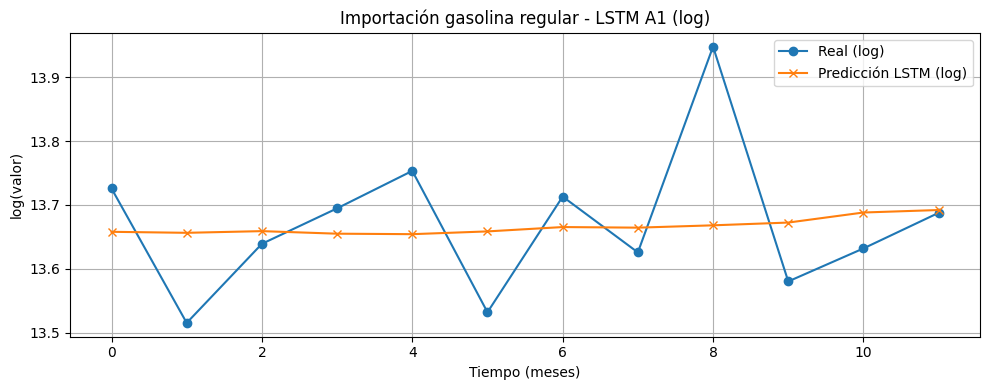

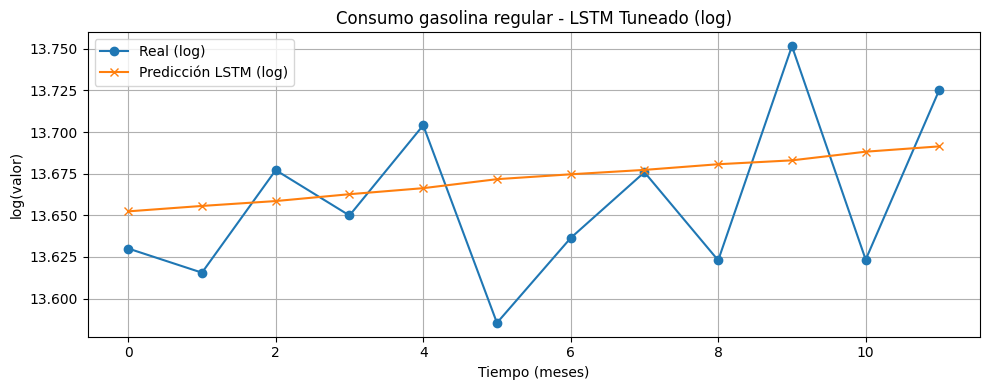

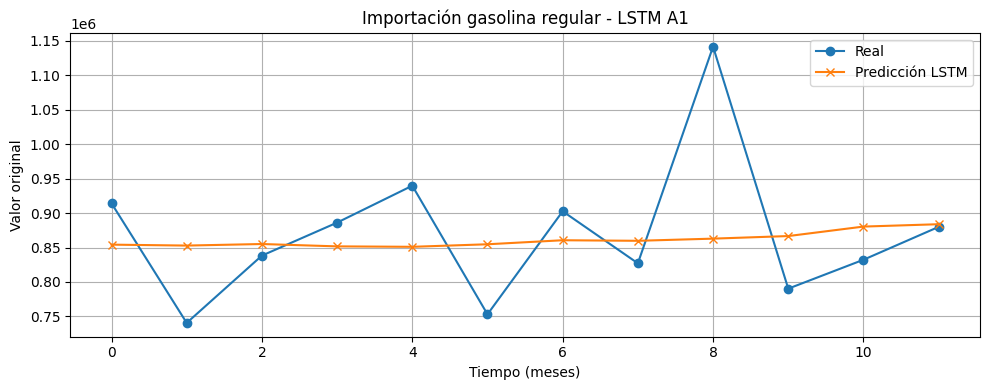

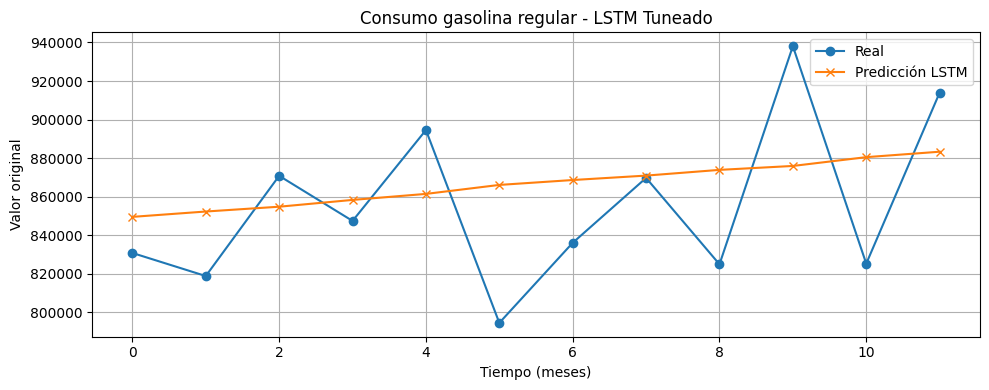

In [10]:
def plot_prediction_log(y_true_log, y_pred_log, title="Predicción vs Real (log)"):
    plt.figure(figsize=(10,4))
    plt.plot(y_true_log, label="Real (log)", marker='o')
    plt.plot(y_pred_log, label="Predicción LSTM (log)", marker='x')
    plt.title(title)
    plt.ylabel("log(valor)")
    plt.xlabel("Tiempo (meses)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_prediction_log(y_true_log_imp, y_pred_log_A1, title="Importación gasolina regular - LSTM A1 (log)")
plot_prediction_log(y_true_log_con, y_pred_log_con_tuneado, title="Consumo gasolina regular - LSTM Tuneado (log)")


def plot_prediction_original(y_true_log, y_pred_log, title="Predicción vs Real (escala original)"):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    
    plt.figure(figsize=(10,4))
    plt.plot(y_true, label="Real", marker='o')
    plt.plot(y_pred, label="Predicción LSTM", marker='x')
    plt.title(title)
    plt.ylabel("Valor original")
    plt.xlabel("Tiempo (meses)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_prediction_original(y_true_log_imp, y_pred_log_A1, title="Importación gasolina regular - LSTM A1")
plot_prediction_original(y_true_log_con, y_pred_log_con_tuneado, title="Consumo gasolina regular - LSTM Tuneado")


Visualmente logramos predecir la tendencia pero los picos no tienden a ser tan exactos, lo cual tiene sentido porque son muy pronunciados, al no ser oficial solo visualmente se podria usar el rmse para evluar:


Revisando ambos labs para extraer los RMSE que se considero como parametro para definir cual es "mejor", porque permite una interpretación directa en las unidades originales de la serie y penaliza outliers 


### Tabla comparativa – RMSE_log

| Serie                      | Modelo           | RMSE_log |
|----------------------------|------------------|----------|
| Importación gasolina       | Prophet (Lab 1)  | 0.2445   |
|                            | LSTM A1          | **0.1129** |
|                            | LSTM Tuneado     | 0.1206   |
| Consumo gasolina           | Prophet (Lab 1)  | 0.0641   |
|                            | LSTM B1          | 0.0589   |
|                            | LSTM Tuneado     | **0.0479** |

### Conclusiones

- En ambas series, los modelos LSTM **superaron a Prophet** en RMSE_log.
- El modelo **LSTM tuneado para consumo** fue el más preciso de todos, con un RMSE_log de 0.0479.
- El modelo **A1 (LSTM simple para importación)** fue mejor que Prophet en log, incluso sin tuning.

En resumen, los **modelos LSTM mostraron mejor desempeño que los modelos del laboratorio anterior** en estas dos series, al menos en la escala logarítmica. Esto demuestra que, con suficiente cantidad de datos y un buen preprocesamiento, los modelos basados en redes neuronales pueden capturar de manera más precisa la dinámica temporal de las series.



# Informe Final – Laboratorio 2: Deep Learning  
### Universidad del Valle de Guatemala  
**Sofía García (22210)**  
**Julio García Salas (22076)**  
**Joaquín Campos (22155)**  

---

## 1. Objetivo  
En este laboratorio se entrenaron y compararon modelos LSTM para dos series temporales (importación y consumo de gasolina regular). Se evaluaron configuraciones simples y apiladas, tanto sin tuning como con tuning de hiperparámetros, para determinar el modelo más adecuado en cada serie.

---

## 2. Preprocesamiento común  
- **Transformación logarítmica** para estabilizar la varianza.  
- **Ventana deslizante** de 24 meses (look‑back = 24).  
- **Normalización** con MinMaxScaler (ajustado solo con datos de entrenamiento).  
- **Predicción 1‑step ahead**: valor del mes *t* predicho con los 24 meses previos.

---

## 3. Modelos LSTM entrenados  

### 3.1 Sin tuning  
| Serie                                  | Modelo   | Arquitectura                                   | LR    | Batch | Dropout |
|----------------------------------------|----------|-------------------------------------------------|-------|-------|---------|
| **Importación gasolina regular (log)** | **A1**   | LSTM(64) → Dense(1)                             | 1e‑3  | 32    | 0.0     |
|                                        | **A2**   | LSTM(64, return_sequences=True) → Dropout(0.2) → LSTM(32) → Dense(1) | 1e‑3  | 32    | 0.2     |
| **Consumo gasolina regular (log)**     | **B1**   | LSTM(64) → Dense(1)                             | 1e‑3  | 32    | 0.0     |
|                                        | **B2**   | LSTM(64, return_sequences=True) → Dropout(0.2) → LSTM(32) → Dense(1) | 1e‑3  | 32    | 0.2     |

### 3.2 Con tuning (Keras Tuner – RandomSearch)  
- Espacio de búsqueda:  
  - units1 ∈ {32, 64, 96, 128}  
  - use_stack ∈ {True, False}  
  - units2 ∈ {16, 32, 48, 64, 80, 96} (si use_stack=True)  
  - dropout ∈ [0.0 … 0.5]  
  - lr ∈ {1e‑2, 5e‑3, 1e‑3, 5e‑4}  
  - batch_size ∈ {16, 32, …, 128}  
- max_trials=20, patience=20, validación 20 %

---

## 4. Resultados de evaluación  

### 4.1 Métricas (test set)  

#### Serie 1 – Importación gasolina regular  

| Modelo                | RMSE_log | MAPE_log | RMSE_orig | MAPE_orig |
|-----------------------|----------|----------|-----------|-----------|
| **A1 (simple)**       | 0.1129   | 0.0065   | **102 788**  | **0.0897**   |
| **A2 (stacked)**      | 0.1288   | 0.0071   | 118 342   | 0.0904    |
| **LSTM tuneado**      | 0.1206   | 0.0066   | 111 342   | 0.0862    |

> **Mejor sin tuning:** A1 (RMSE_orig 102 788)  
> **Con tuning:** mejora MAPE (0.0862 vs 0.0897) pero empeora RMSE.

#### Serie 2 – Consumo gasolina regular  

| Modelo                | RMSE_log | MAPE_log | RMSE_orig | MAPE_orig |
|-----------------------|----------|----------|-----------|-----------|
| **B1 (simple)**       | 0.0589   | 0.0035   | **50 820**   | **0.0467**   |
| **B2 (stacked)**      | 0.0650   | 0.0037   | 55 885    | 0.0493    |
| **LSTM tuneado**      | 0.0479   | 0.0029   | 41 488    | 0.0395    |

> **Mejor sin tuning:** B1 (RMSE_orig 50 820)  
> **Con tuning:** mejora clara en ambas métricas (–18.4 % RMSE, –15.4 % MAPE).

---
## 5. Criterios de comparación  

Para evaluar de forma rigurosa la calidad de los pronósticos, definimos dos grupos de métricas: unas en escala logarítmica y otras en la escala original de la serie.

### 5.1 Métricas en escala logarítmica  
- **RMSE_log** (Root Mean Squared Error en log):  
  - Calcula la raíz del error cuadrático medio sobre los datos transformados con log.  
  - Ayuda a estabilizar la varianza cuando los valores crecen exponencialmente y suaviza la influencia de los picos extremos.  
  - Permite comparar la forma general de la curva de predicción sin que los valores más grandes dominen la métrica.  
- **MAPE_log** (Mean Absolute Percentage Error en log):  
  - Mide el error porcentual medio absoluto en el espacio logarítmico.  
  - Indica la precisión relativa en la forma de la serie transformada, independiente de la magnitud absoluta.  
  - Útil para detectar sesgos sistemáticos de sobre‑ o sub‑estimación en tendencias relativas.

### 5.2 Métricas en escala original  
- **RMSE_orig** (Root Mean Squared Error en unidades originales):  
  - Se obtiene tras invertir la transformación log y la normalización MinMax.  
  - Expresado en las mismas unidades de la serie (por ejemplo, quetzales).  
  - Penaliza fuertemente los errores grandes, lo que es clave para controlar desviaciones costosas en la práctica.  
- **MAPE_orig** (Mean Absolute Percentage Error en unidades originales):  
  - Calcula el error porcentual medio absoluto respecto al valor real.  
  - Proporciona una medida intuitiva de la precisión: “¿qué porcentaje, en promedio, me equivoco?”  
  - Permite comparar la exactitud relativa entre series con distintos rangos de magnitudes.

> • **RMSE_orig** muestra el impacto monetario/promedio de los errores.  
> • **MAPE_orig** garantiza que no sacrifiquemos el error en valores bajos a cambio de mejorar los picos.

### 5.3 Selección de mejor modelo  
1. **Priorizar RMSE_orig**  
   - Ofrece una medida directa del tamaño del error en unidades reales: esencial para decisiones de negocio.  
2. **Corroborar con MAPE_orig**  
   - Verifica que la mejora en RMSE_orig no incremente desproporcionadamente el error porcentual.  
   - Asegura robustez y consistencia de las predicciones a lo largo de todo el rango de valores.

En conjunto, estas métricas permiten equilibrar precisión absoluta y relativa, eligiendo el modelo que minimice el error en unidades reales sin sacrificar un buen desempeño porcentual general.  

---

## 6. Conclusiones  

1. **Modelos simples (A1 y B1)** son *baselines* robustos:  
   - A1 ganó en RMSE_orig para importación.  
   - B1 ganó en RMSE_orig para consumo (sin tuning).  

2. **Tuning**:  
   - **Serie 1 (importación):** no supera RMSE_base, aunque mejora MAPE.  
   - **Serie 2 (consumo):** tuning sí valió la pena → reduce RMSE ~ 18 % y MAPE ~ 15 %.

3. **Mejor modelo por serie de tiempo**:  
   - **Importación gasolina regular:** **A1 (simple)** → RMSE_orig más bajo.  
   - **Consumo gasolina regular:** **LSTM tuneado** → mejores RMSE_orig y MAPE_orig.

4. **Recomendaciones futuras**:  
   - Explorar ventanas de 12 y 36 meses.  
   - Probar otros optimizadores o arquitecturas (GRU, Transformer).  
   - Ajustar estrategias de regularización para “stacked” sin degradar RMSE.

